# Experimentación y Entrenamiento del Modelo.

## 1.1. Importación de liberías.

In [34]:
import os
import warnings
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

In [35]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient
import joblib

## 1.2. Configuraciones.

In [36]:
warnings.filterwarnings('ignore')

In [37]:
# Configurar estilo de gráficas
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [38]:
# Configurar MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
print(f"✓ Tracking URI: {mlflow.get_tracking_uri()}")
mlflow.set_experiment("wine-quality-classifier")

experiment_name = "wine-quality-classifier"
experiment_description = """
Experimento para clasificación binaria de calidad de vino blanco.
Objetivo: Predecir si un vino es de alta calidad (≥6) o baja calidad (<6)
basándose en sus propiedades fisicoquímicas.

Dataset: Wine Quality Dataset (Kaggle)
Modelo: Random Forest Classifier
"""
experiment_tags = {
    "owner": "Tobias",
    "project": "wine-quality-mlops",
    "dataset": "winequality",
    "dataset_version": "1.0",
    "problem_type": "binary_classification",
    "model_family": "RandomForest",
    "framework": "scikit-learn",
    "created_date": datetime.now().strftime("%Y-%m-%d"),
    "environment": "development"
}
client = MlflowClient()
exp = mlflow.get_experiment_by_name(experiment_name)

# Si el experimento está eliminado, restaurarlo
if exp and getattr(exp, "lifecycle_stage", None) == "deleted":
    print(f"\n Restaurando experimento eliminado: {experiment_name}")
    client.restore_experiment(exp.experiment_id)
    exp = mlflow.get_experiment_by_name(experiment_name)

# Crear experimento si no existe
if exp is None:
    print(f"\n Creando nuevo experimento: {experiment_name}")
    exp_id = client.create_experiment(
        name=experiment_name,
        tags=experiment_tags
    )
else:
    print(f"\n Usando experimento existente: {experiment_name}")
    exp_id = exp.experiment_id

    for key, value in experiment_tags.items():
        client.set_experiment_tag(exp_id, key, value)

client.set_experiment_tag(exp_id, "mlflow.note.content", experiment_description)

mlflow.set_experiment(experiment_name)

exp_actualizado = mlflow.get_experiment(exp_id)

print(f"\n Experimento configurado correctamente:")
print(f"   ✓ Nombre: {exp_actualizado.name}")
print(f"   ✓ ID: {exp_actualizado.experiment_id}")
print(f"   ✓ Artifact Location: {exp_actualizado.artifact_location}")
print(f"   ✓ Lifecycle Stage: {exp_actualizado.lifecycle_stage}")

print(f"\n Tags del experimento:")
for key, value in exp_actualizado.tags.items():
    if key != "mlflow.note.content":
        print(f"   • {key}: {value}")

print(f"\n Descripción del experimento:")
description = exp_actualizado.tags.get("mlflow.note.content", "(sin descripción)")
print(f"   {description[:200]}...")

# Crear carpeta temporal para artifacts (se limpiará al final)
temp_artifacts_dir = "temp_artifacts"
os.makedirs(temp_artifacts_dir, exist_ok=True)

print(f"\n Carpeta temporal para artifacts: {temp_artifacts_dir}/")
experiment = mlflow.get_experiment_by_name(experiment_name)

✓ Tracking URI: http://127.0.0.1:5000


2025/11/07 18:35:41 INFO mlflow.tracking.fluent: Experiment with name 'wine-quality-classifier' does not exist. Creating a new experiment.



 Usando experimento existente: wine-quality-classifier

 Experimento configurado correctamente:
   ✓ Nombre: wine-quality-classifier
   ✓ ID: 406487776128336594
   ✓ Artifact Location: mlflow-artifacts:/406487776128336594
   ✓ Lifecycle Stage: active

 Tags del experimento:
   • created_date: 2025-11-07
   • dataset: winequality
   • dataset_version: 1.0
   • environment: development
   • framework: scikit-learn
   • model_family: RandomForest
   • owner: Tobias
   • problem_type: binary_classification
   • project: wine-quality-mlops

 Descripción del experimento:
   
Experimento para clasificación binaria de calidad de vino blanco.
Objetivo: Predecir si un vino es de alta calidad (≥6) o baja calidad (<6)
basándose en sus propiedades fisicoquímicas.

Dataset: Wine...

 Carpeta temporal para artifacts: temp_artifacts/


## 2. Carga y exploración de datos.

In [39]:
dataset_path = "../data/winequality.csv"

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"No se encontró el dataset en: {dataset_path}")

print(f"✓ Dataset encontrado: {dataset_path}")

✓ Dataset encontrado: ../data/winequality.csv


In [40]:
df = pd.read_csv(dataset_path, sep=";")

In [41]:
print("Primeras filas:")
print(df.head())

print("\nInformación del dataset:")
print(df.info())

print("\nEstadísticas descriptivas:")
print(df.describe())

print(f"\nDistribución de calidad:")
quality_dist = df['quality'].value_counts().sort_index()
print(quality_dist)

Primeras filas:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2   

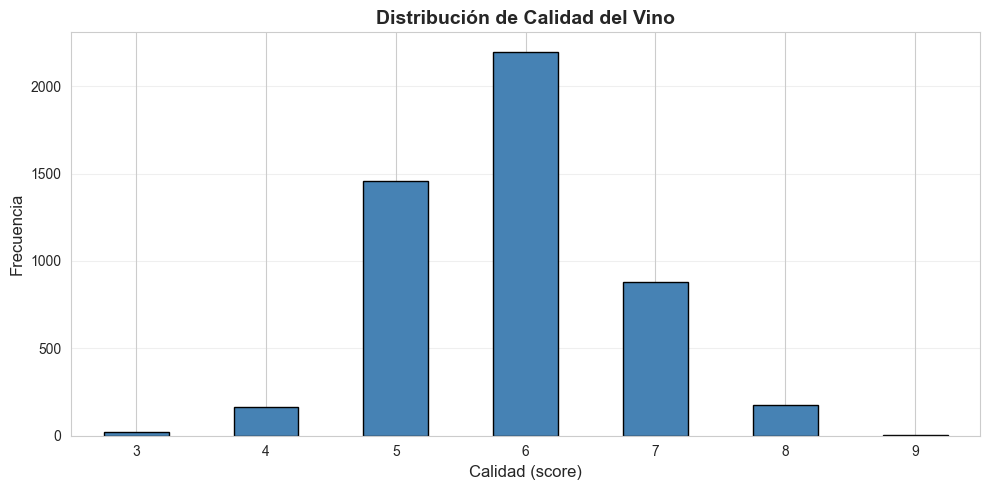

In [42]:
plt.figure(figsize=(10, 5))
quality_dist.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Distribución de Calidad del Vino', fontsize=14, fontweight='bold')
plt.xlabel('Calidad (score)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{temp_artifacts_dir}/01_quality_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

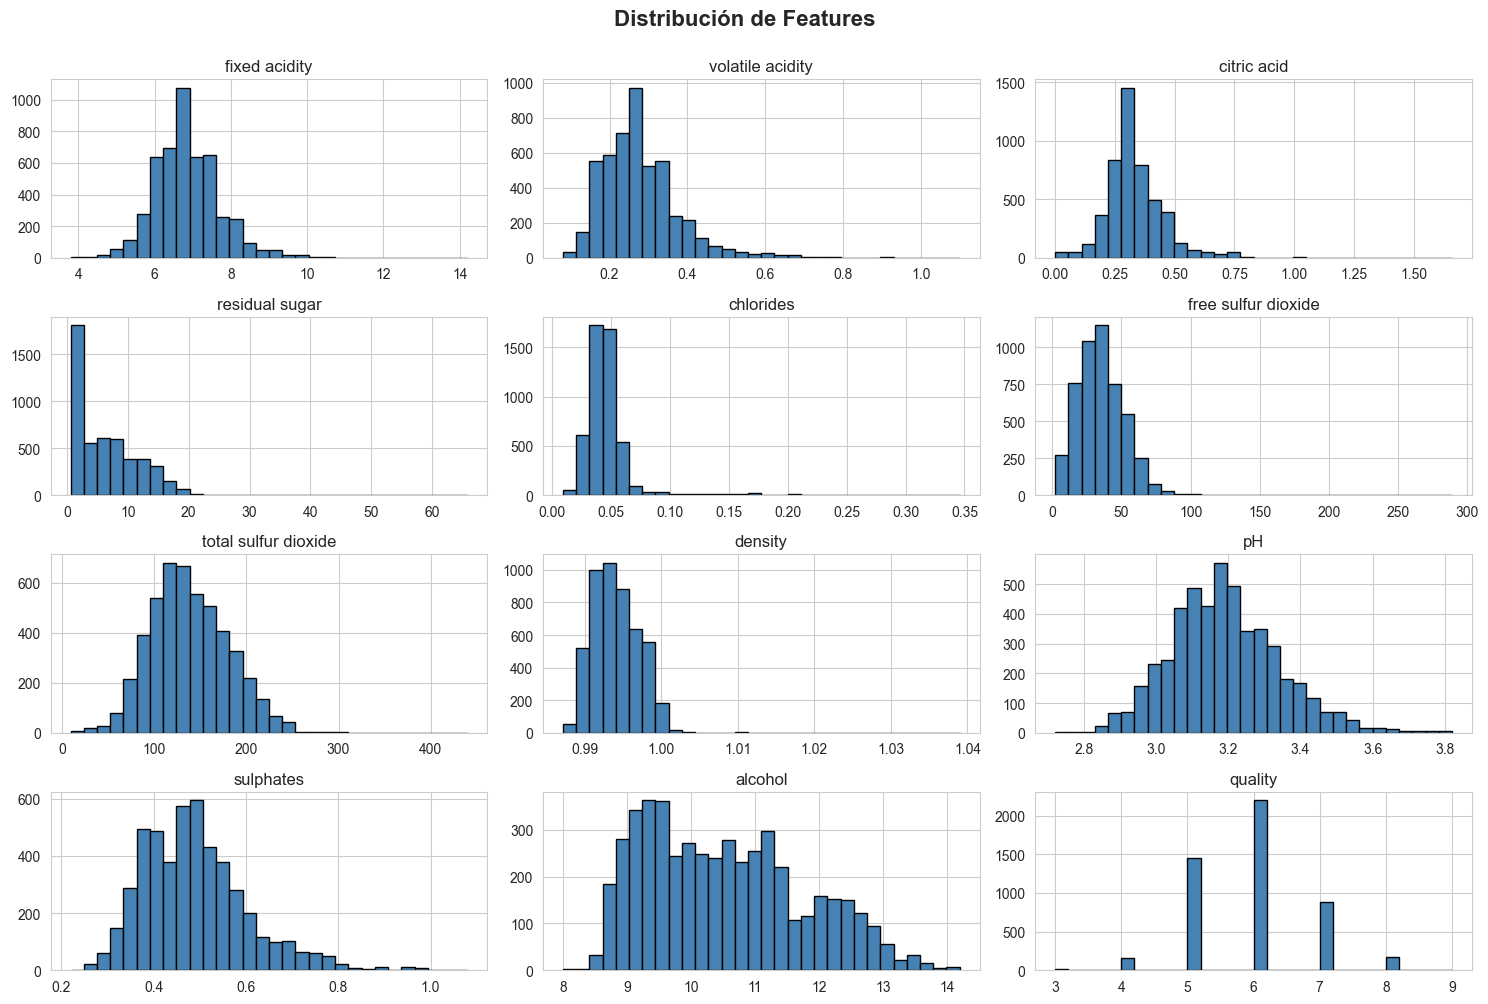

In [43]:
fig = df.hist(bins=30, figsize=(15, 10), color='steelblue', edgecolor='black')
plt.suptitle('Distribución de Features', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(f'{temp_artifacts_dir}/02_features_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

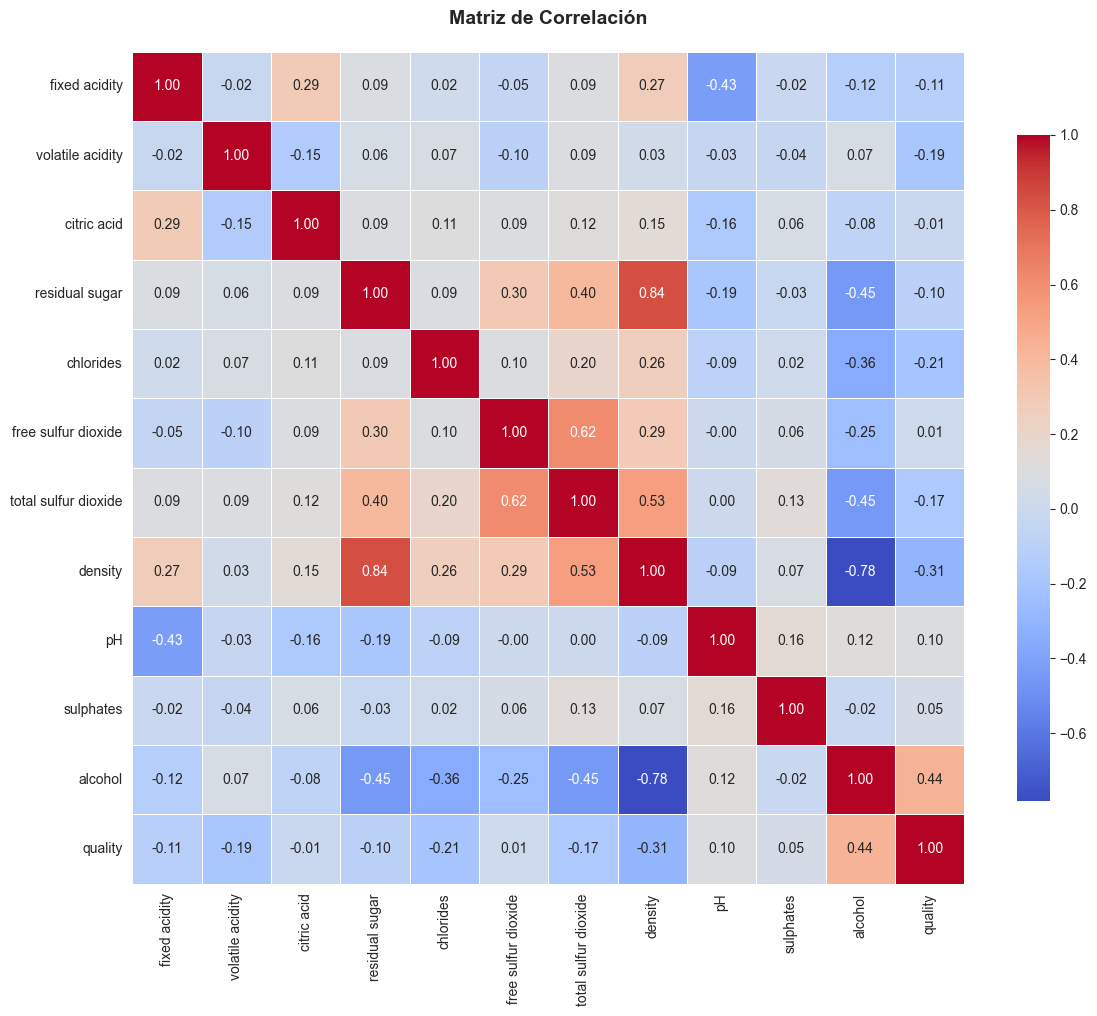

In [44]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f',
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{temp_artifacts_dir}/03_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [45]:
print("\n Correlación de features con 'quality':")
quality_corr = correlation_matrix['quality'].sort_values(ascending=False)
print(quality_corr)


 Correlación de features con 'quality':
quality                 1.000000
alcohol                 0.435575
pH                      0.099427
sulphates               0.053678
free sulfur dioxide     0.008158
citric acid            -0.009209
residual sugar         -0.097577
fixed acidity          -0.113663
total sulfur dioxide   -0.174737
volatile acidity       -0.194723
chlorides              -0.209934
density                -0.307123
Name: quality, dtype: float64


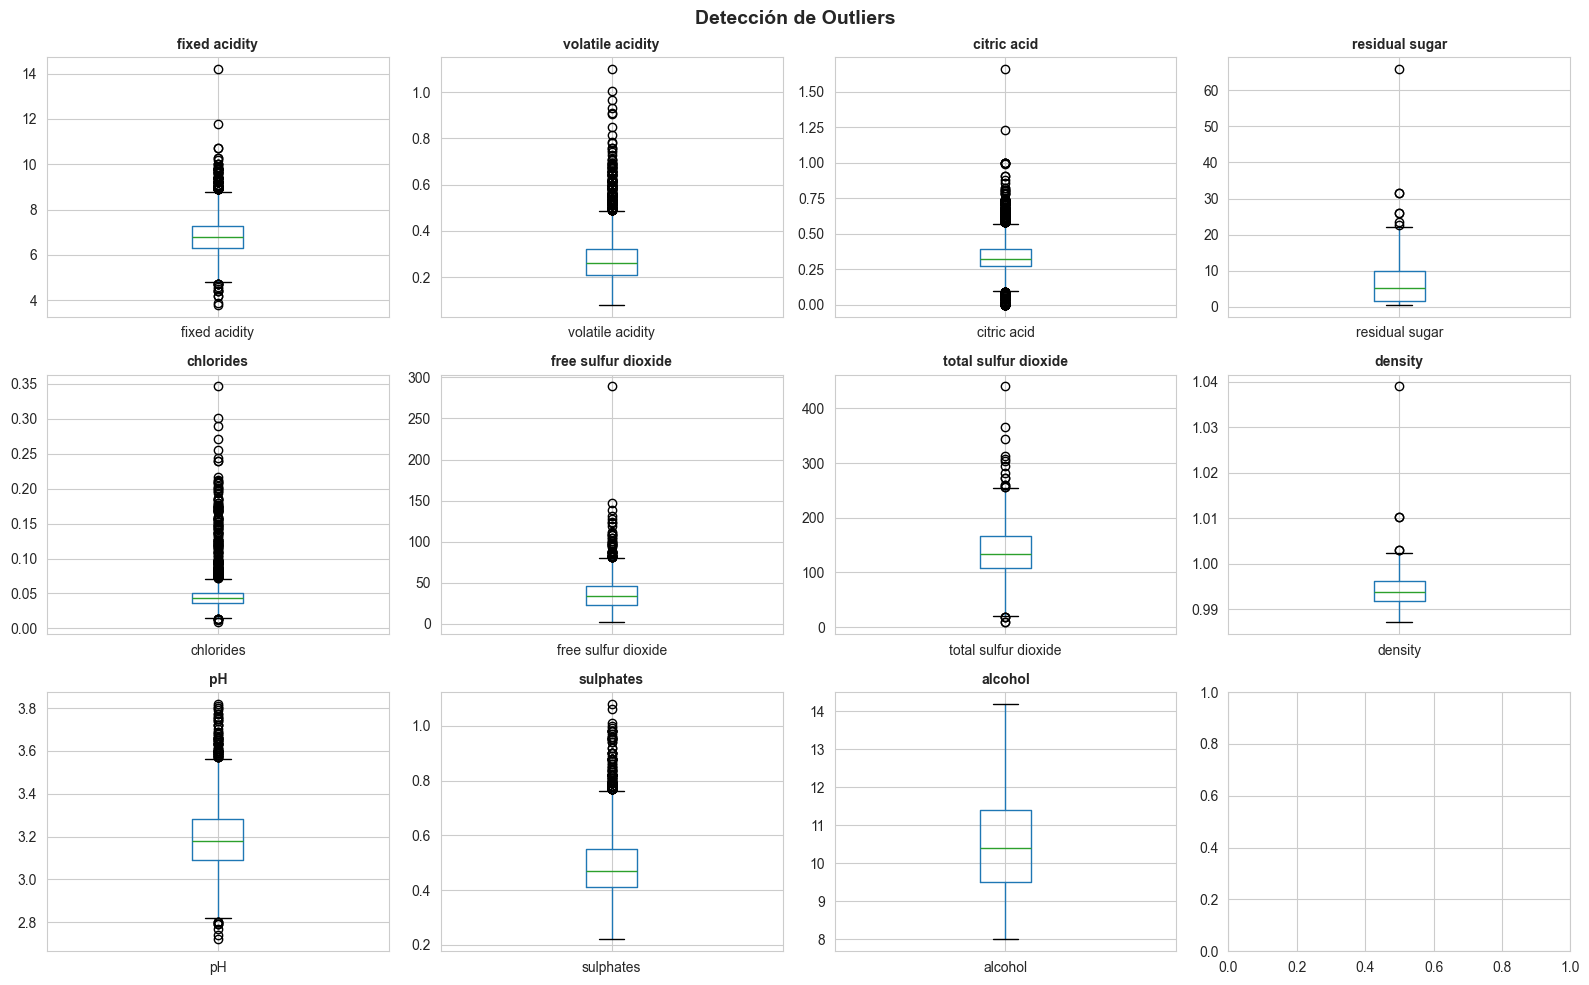

In [46]:
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.ravel()
for idx, col in enumerate(df.columns[:-1]):  # Excluir 'quality'
    df.boxplot(column=col, ax=axes[idx])
    axes[idx].set_title(col, fontsize=10, fontweight='bold')
plt.suptitle('Detección de Outliers', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{temp_artifacts_dir}/04_outliers_detection.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Preparación de los datos.

In [47]:
threshold = 6
df['quality_class'] = (df['quality'] >= threshold).astype(int)
print(f"✓ Umbral de clasificación: quality >= {threshold}")
print(f"  - Clase 0 (Baja): quality < {threshold}")
print(f"  - Clase 1 (Alta): quality >= {threshold}")

✓ Umbral de clasificación: quality >= 6
  - Clase 0 (Baja): quality < 6
  - Clase 1 (Alta): quality >= 6


In [48]:
print(f"\n Distribución de clases:")
class_dist = df['quality_class'].value_counts().sort_index()
print(class_dist)


 Distribución de clases:
quality_class
0    1640
1    3258
Name: count, dtype: int64


In [49]:
print(f"\n Porcentaje por clase:")
class_pct = df['quality_class'].value_counts(normalize=True).sort_index() * 100
for cls, pct in class_pct.items():
    print(f"  Clase {cls}: {pct:.2f}%")


 Porcentaje por clase:
  Clase 0: 33.48%
  Clase 1: 66.52%


In [50]:
X = df.drop(['quality', 'quality_class'], axis=1)
y = df['quality_class']

In [51]:
feature_names = X.columns.tolist()
n_features = len(feature_names)
print(f"\nFeatures ({n_features} totales):")
for i, col in enumerate(feature_names, 1):
    print(f"  {i:2d}. {col}")



Features (11 totales):
   1. fixed acidity
   2. volatile acidity
   3. citric acid
   4. residual sugar
   5. chlorides
   6. free sulfur dioxide
   7. total sulfur dioxide
   8. density
   9. pH
  10. sulphates
  11. alcohol


In [52]:
test_size = 0.2
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y
)

print(f"\n División del dataset:")
print(f"  Training:   {len(X_train):4d} muestras ({(1-test_size)*100:.0f}%)")
print(f"  Test:       {len(X_test):4d} muestras ({test_size*100:.0f}%)")
print(f"  Total:      {len(df):4d} muestras")


 División del dataset:
  Training:   3918 muestras (80%)
  Test:        980 muestras (20%)
  Total:      4898 muestras


In [53]:
dataset_info = {
    'total_samples': len(df),
    'n_features': n_features,
    'feature_names': feature_names,
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'test_size': test_size,
    'random_state': random_state,
    'threshold': threshold,
    'class_distribution': class_dist.to_dict()
}

## 4. Entrenamiento del modelo.

In [54]:
# Definimos configuraciones de hiperparámetros para experimentar
experiments = [
    {
        'name': 'baseline_small',
        'n_estimators': 50,
        'max_depth': 10,
        'min_samples_split': 2,
        'description': 'Modelo baseline con pocos árboles para establecer línea base'
    },
    {
        'name': 'balanced_medium',
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 5,
        'description': 'Configuración balanceada con regularización moderada'
    },
    {
        'name': 'deep_trees',
        'n_estimators': 100,
        'max_depth': 15,
        'min_samples_split': 2,
        'description': 'Árboles más profundos para capturar mayor complejidad'
    },
    {
        'name': 'large_forest',
        'n_estimators': 200,
        'max_depth': 15,
        'min_samples_split': 5,
        'description': 'Bosque grande con regularización para mejor generalización'
    },
]

results = []

for i, exp_config in enumerate(experiments, 1):
    print(f"EXPERIMENTO {i}/{len(experiments)}: {exp_config['name'].upper()}")
    print(f"Descripción: {exp_config['description']}")
    print(f"Parámetros:")
    print(f"  - n_estimators: {exp_config['n_estimators']}")
    print(f"  - max_depth: {exp_config['max_depth']}")
    print(f"  - min_samples_split: {exp_config['min_samples_split']}")

    run_name = f"{exp_config['name']}_RF"

    with mlflow.start_run(run_name=run_name) as run:
        print(f"\n Configurando tags y metadatos del run...")

        run_tags = {
            # Identificación del experimento
            "experiment_config": exp_config['name'],
            "experiment_number": str(i),
            "total_experiments": str(len(experiments)),

            # Información del modelo
            "model_type": "RandomForest",
            "model_family": "tree-based",
            "framework": "scikit-learn",

            # Información del dataset
            "dataset_name": "winequality",
            "dataset_version": "1.0",
            "dataset_source": "Kaggle",
            "problem_type": "binary_classification",
            "target_variable": "quality_class",

            # Configuración de entrenamiento
            "training_date": datetime.now().strftime("%Y-%m-%d"),
            "training_time": datetime.now().strftime("%H:%M:%S"),
            "random_state": str(random_state),

            # Metadata del proyecto
            "project": "wine-quality-mlops",
            "author": "Tobías",
            "environment": "development",
            "python_version": "3.9"
        }

        mlflow.set_tags(run_tags)

        # Descripción detallada del run
        run_description = f"""
# {exp_config['name'].upper()} - Random Forest Classifier

## Descripción del Experimento
{exp_config['description']}

## Configuración del Modelo
- **Algoritmo:** Random Forest Classifier
- **N° de árboles:** {exp_config['n_estimators']}
- **Profundidad máxima:** {exp_config['max_depth']}
- **Min samples split:** {exp_config['min_samples_split']}
- **Random state:** {random_state}

## Dataset
- **Nombre:** Wine Quality
- **Total de muestras:** {len(df)}
- **Features:** {n_features}
- **Target:** Clasificación binaria (Alta/Baja calidad)
- **Training samples:** {len(X_train)} ({(1 - test_size) * 100:.0f}%)
- **Test samples:** {len(X_test)} ({test_size * 100:.0f}%)

---
**Ejecutado:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
"""

        mlflow.set_tag("mlflow.note.content", run_description)

        print(f" Entrenando modelo...")

        start_time = datetime.now()

        model = RandomForestClassifier(
            n_estimators=exp_config['n_estimators'],
            max_depth=exp_config['max_depth'],
            min_samples_split=exp_config['min_samples_split'],
            random_state=random_state,
            n_jobs=-1,
            verbose=0
        )

        model.fit(X_train, y_train)

        training_time = (datetime.now() - start_time).total_seconds()

        print(f"✓ Entrenamiento completado")

        print(f" Generando predicciones...")

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        print(f" Calculando métricas...")

        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba),
            'training_time_seconds': training_time
        }

        print(f"\n Métricas obtenidas:")
        for metric_name, metric_value in metrics.items():
            if 'time' in metric_name:
                print(f"  {metric_name}: {metric_value:.2f}s")
            else:
                print(f"  {metric_name}: {metric_value:.4f}")

        print(f"\nRegistrando parámetros en MLflow...")

        params_to_log = {
            # Hiperparámetros del modelo
            'n_estimators': exp_config['n_estimators'],
            'max_depth': exp_config['max_depth'],
            'min_samples_split': exp_config['min_samples_split'],
            'random_state': random_state,
            'n_jobs': -1,

            # Configuración del dataset
            'test_size': test_size,
            'quality_threshold': threshold,
            'n_features': n_features,
            'train_samples': len(X_train),
            'test_samples': len(X_test),

            # Información adicional
            'model_type': 'RandomForest',
            'experiment_config': exp_config['name']
        }

        mlflow.log_params(params_to_log)

        print(f"Registrando métricas en MLflow...")

        mlflow.log_metrics(metrics)

        print(f" Registrando información del dataset...")

        # Guardar info del dataset como JSON
        import json

        with open(f'{temp_artifacts_dir}/dataset_info.json', 'w') as f:
            json.dump(dataset_info, f, indent=2)
        mlflow.log_artifact(f'{temp_artifacts_dir}/dataset_info.json', 'dataset')

        print(f"Generando y registrando visualizaciones...")

        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Baja (<6)', 'Alta (≥6)'],
                    yticklabels=['Baja (<6)', 'Alta (≥6)'],
                    annot_kws={'size': 14, 'weight': 'bold'})
        plt.title(f'Matriz de Confusión - {run_name}',
                  fontsize=14, fontweight='bold', pad=15)
        plt.ylabel('Clase Real', fontsize=12, fontweight='bold')
        plt.xlabel('Clase Predicha', fontsize=12, fontweight='bold')
        plt.text(0.5, 1.08, f"Accuracy: {metrics['accuracy']:.4f}",
                 ha='center', va='center', transform=plt.gca().transAxes,
                 fontsize=11, style='italic')
        plt.tight_layout()
        cm_path = f'{temp_artifacts_dir}/confusion_matrix_exp{i}.png'
        plt.savefig(cm_path, dpi=150, bbox_inches='tight')
        mlflow.log_artifact(cm_path, 'plots')
        plt.close()

        # ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (AUC = {metrics["roc_auc"]:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold')
        plt.ylabel('True Positive Rate (TPR)', fontsize=12, fontweight='bold')
        plt.title(f'ROC Curve - {run_name}', fontsize=14, fontweight='bold', pad=15)
        plt.legend(loc="lower right", fontsize=10)
        plt.grid(alpha=0.3, linestyle='--')
        plt.tight_layout()
        roc_path = f'{temp_artifacts_dir}/roc_curve_exp{i}.png'
        plt.savefig(roc_path, dpi=150, bbox_inches='tight')
        mlflow.log_artifact(roc_path, 'plots')
        plt.close()

        # Métricas comparativas
        fig, ax = plt.subplots(figsize=(10, 6))
        metric_names = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC-AUC']
        metric_values = [
            metrics['accuracy'],
            metrics['f1_score'],
            metrics['precision'],
            metrics['recall'],
            metrics['roc_auc']
        ]

        colors_map = ['#2ecc71' if v >= 0.75 else '#f39c12' if v >= 0.65 else '#e74c3c'
                      for v in metric_values]
        bars = ax.barh(metric_names, metric_values, color=colors_map)

        ax.set_xlabel('Score', fontsize=12, fontweight='bold')
        ax.set_title(f'Resumen de Métricas - {run_name}',
                     fontsize=14, fontweight='bold', pad=15)
        ax.set_xlim([0, 1])
        ax.grid(axis='x', alpha=0.3, linestyle='--')

        for idx, (bar, val) in enumerate(zip(bars, metric_values)):
            ax.text(val + 0.02, bar.get_y() + bar.get_height() / 2,
                    f'{val:.4f}', va='center', fontsize=10, fontweight='bold')

        plt.tight_layout()
        metrics_path = f'{temp_artifacts_dir}/metrics_summary_exp{i}.png'
        plt.savefig(metrics_path, dpi=150, bbox_inches='tight')
        mlflow.log_artifact(metrics_path, 'plots')
        plt.close()

        report = classification_report(y_test, y_pred,
                                       target_names=['Baja', 'Alta'],
                                       output_dict=False)
        print("\n Classification Report:")
        print(report)

        # Guardar report como artifact
        report_path = f'{temp_artifacts_dir}/classification_report_exp{i}.txt'
        with open(report_path, 'w') as f:
            f.write(f"Classification Report - {run_name}\n")
            f.write("=" * 50 + "\n\n")
            f.write(report)
        mlflow.log_artifact(report_path, 'reports')

        print(f" Guardando modelo en MLflow...")

        # Crear signature
        signature = infer_signature(X_train, model.predict(X_train))

        # Preparar input example
        input_example = X_train.iloc[:3]

        # Información adicional del modelo
        model_metadata = {
            "model_type": "RandomForest",
            "sklearn_version": "1.3.2",
            "n_estimators": exp_config['n_estimators'],
            "max_depth": exp_config['max_depth'],
            "feature_names": feature_names,
            "target_names": ["Baja (<6)", "Alta (≥6)"],
            "training_samples": len(X_train),
            "training_time_seconds": training_time,
            "threshold_quality": threshold,
            "experiment_config": exp_config['name']
        }

        # Log modelo con metadata
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            signature=signature,
            input_example=input_example,
            registered_model_name=None,  # No registrar aún en el registry
            metadata=model_metadata
        )

        print(f"✓ Modelo guardado")

        print(f" Registrando datasets...")

        # Guardar datasets de train y test
        train_features_path = f'{temp_artifacts_dir}/train_features_exp{i}.csv'
        train_target_path = f'{temp_artifacts_dir}/train_target_exp{i}.csv'
        test_features_path = f'{temp_artifacts_dir}/test_features_exp{i}.csv'
        test_target_path = f'{temp_artifacts_dir}/test_target_exp{i}.csv'

        X_train.to_csv(train_features_path, index=False)
        y_train.to_csv(train_target_path, index=False, header=['quality_class'])
        X_test.to_csv(test_features_path, index=False)
        y_test.to_csv(test_target_path, index=False, header=['quality_class'])

        mlflow.log_artifact(train_features_path, 'dataset/train')
        mlflow.log_artifact(train_target_path, 'dataset/train')
        mlflow.log_artifact(test_features_path, 'dataset/test')
        mlflow.log_artifact(test_target_path, 'dataset/test')

        # Guardar dataset original (solo en el primer experimento)
        if i == 1:
            mlflow.log_artifact(dataset_path, 'dataset/original')

        print(f"✓ Datasets registrados")

        run_id = run.info.run_id

        # Construir URL del run
        run_url = f"file:///{os.path.abspath('./mlruns')}/{exp_id}/{run_id}"

        results.append({
            'experiment': i,
            'name': exp_config['name'],
            'run_id': run_id,
            'run_name': run_name,
            'run_url': run_url,
            **{k: v for k, v in exp_config.items() if k not in ['name', 'description']},
            **metrics
        })

        print(f"\n Experimento {i} completado")
        print(f"   Run ID: {run_id}")
        print(f"   Artifacts guardados en: mlruns/{exp_id}/{run_id}/artifacts/")

    print("TODOS LOS EXPERIMENTOS COMPLETADOS")

EXPERIMENTO 1/4: BASELINE_SMALL
Descripción: Modelo baseline con pocos árboles para establecer línea base
Parámetros:
  - n_estimators: 50
  - max_depth: 10
  - min_samples_split: 2

 Configurando tags y metadatos del run...
 Entrenando modelo...
✓ Entrenamiento completado
 Generando predicciones...
 Calculando métricas...

 Métricas obtenidas:
  accuracy: 0.8102
  f1_score: 0.8616
  precision: 0.8367
  recall: 0.8880
  roc_auc: 0.8748
  training_time_seconds: 0.35s

Registrando parámetros en MLflow...
Registrando métricas en MLflow...
 Registrando información del dataset...
Generando y registrando visualizaciones...

 Classification Report:
              precision    recall  f1-score   support

        Baja       0.75      0.66      0.70       328
        Alta       0.84      0.89      0.86       652

    accuracy                           0.81       980
   macro avg       0.79      0.77      0.78       980
weighted avg       0.81      0.81      0.81       980

 Guardando modelo en ML

2025/11/07 18:36:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Modelo guardado
 Registrando datasets...
✓ Datasets registrados

 Experimento 1 completado
   Run ID: ef6528f363af4cf9971c25b5b78eb1e0
   Artifacts guardados en: mlruns/406487776128336594/ef6528f363af4cf9971c25b5b78eb1e0/artifacts/
🏃 View run baseline_small_RF at: http://127.0.0.1:5000/#/experiments/406487776128336594/runs/ef6528f363af4cf9971c25b5b78eb1e0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/406487776128336594
TODOS LOS EXPERIMENTOS COMPLETADOS
EXPERIMENTO 2/4: BALANCED_MEDIUM
Descripción: Configuración balanceada con regularización moderada
Parámetros:
  - n_estimators: 100
  - max_depth: 10
  - min_samples_split: 5

 Configurando tags y metadatos del run...
 Entrenando modelo...
✓ Entrenamiento completado
 Generando predicciones...
 Calculando métricas...

 Métricas obtenidas:
  accuracy: 0.8112
  f1_score: 0.8620
  precision: 0.8389
  recall: 0.8865
  roc_auc: 0.8729
  training_time_seconds: 0.30s

Registrando parámetros en MLflow...
Registrando métricas en ML

2025/11/07 18:36:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 Classification Report:
              precision    recall  f1-score   support

        Baja       0.75      0.66      0.70       328
        Alta       0.84      0.89      0.86       652

    accuracy                           0.81       980
   macro avg       0.79      0.77      0.78       980
weighted avg       0.81      0.81      0.81       980

 Guardando modelo en MLflow...
✓ Modelo guardado
 Registrando datasets...
✓ Datasets registrados

 Experimento 2 completado
   Run ID: 05c825145d984ef3b159bac6bb051cd5
   Artifacts guardados en: mlruns/406487776128336594/05c825145d984ef3b159bac6bb051cd5/artifacts/
🏃 View run balanced_medium_RF at: http://127.0.0.1:5000/#/experiments/406487776128336594/runs/05c825145d984ef3b159bac6bb051cd5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/406487776128336594
TODOS LOS EXPERIMENTOS COMPLETADOS
EXPERIMENTO 3/4: DEEP_TREES
Descripción: Árboles más profundos para capturar mayor complejidad
Parámetros:
  - n_estimators: 100
  - max_depth: 

2025/11/07 18:36:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 Classification Report:
              precision    recall  f1-score   support

        Baja       0.78      0.71      0.74       328
        Alta       0.86      0.90      0.88       652

    accuracy                           0.83       980
   macro avg       0.82      0.80      0.81       980
weighted avg       0.83      0.83      0.83       980

 Guardando modelo en MLflow...
✓ Modelo guardado
 Registrando datasets...
✓ Datasets registrados

 Experimento 3 completado
   Run ID: 30aa7f706eb44b1e84cb73b1e26e80f6
   Artifacts guardados en: mlruns/406487776128336594/30aa7f706eb44b1e84cb73b1e26e80f6/artifacts/
🏃 View run deep_trees_RF at: http://127.0.0.1:5000/#/experiments/406487776128336594/runs/30aa7f706eb44b1e84cb73b1e26e80f6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/406487776128336594
TODOS LOS EXPERIMENTOS COMPLETADOS
EXPERIMENTO 4/4: LARGE_FOREST
Descripción: Bosque grande con regularización para mejor generalización
Parámetros:
  - n_estimators: 200
  - max_depth

2025/11/07 18:36:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 Classification Report:
              precision    recall  f1-score   support

        Baja       0.78      0.72      0.75       328
        Alta       0.86      0.90      0.88       652

    accuracy                           0.84       980
   macro avg       0.82      0.81      0.81       980
weighted avg       0.84      0.84      0.84       980

 Guardando modelo en MLflow...
✓ Modelo guardado
 Registrando datasets...
✓ Datasets registrados

 Experimento 4 completado
   Run ID: f8dca8c791f646d68ba8cf142d6b57fe
   Artifacts guardados en: mlruns/406487776128336594/f8dca8c791f646d68ba8cf142d6b57fe/artifacts/
🏃 View run large_forest_RF at: http://127.0.0.1:5000/#/experiments/406487776128336594/runs/f8dca8c791f646d68ba8cf142d6b57fe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/406487776128336594
TODOS LOS EXPERIMENTOS COMPLETADOS


## 5. Análisis de resultados.

Resultados de todos los experimentos:

 experiment            name  n_estimators  max_depth  accuracy  f1_score  roc_auc  training_time_seconds
          1  baseline_small            50         10  0.810204  0.861607 0.874825               0.351604
          2 balanced_medium           100         10  0.811224  0.862043 0.872882               0.300164
          3      deep_trees           100         15  0.834694  0.878561 0.901214               0.350850
          4    large_forest           200         15  0.837755  0.880361 0.896458               0.635967

 MEJOR MODELO (según accuracy):
  Experimento: 4 - large_forest
  Configuración:
    - n_estimators: 200
    - max_depth: 15
    - min_samples_split: 5
  Métricas:
    - Accuracy:  0.8378
    - F1-Score:  0.8804
    - Precision: 0.8641
    - Recall:    0.8972
    - ROC-AUC:   0.8965
  Run ID: f8dca8c791f646d68ba8cf142d6b57fe


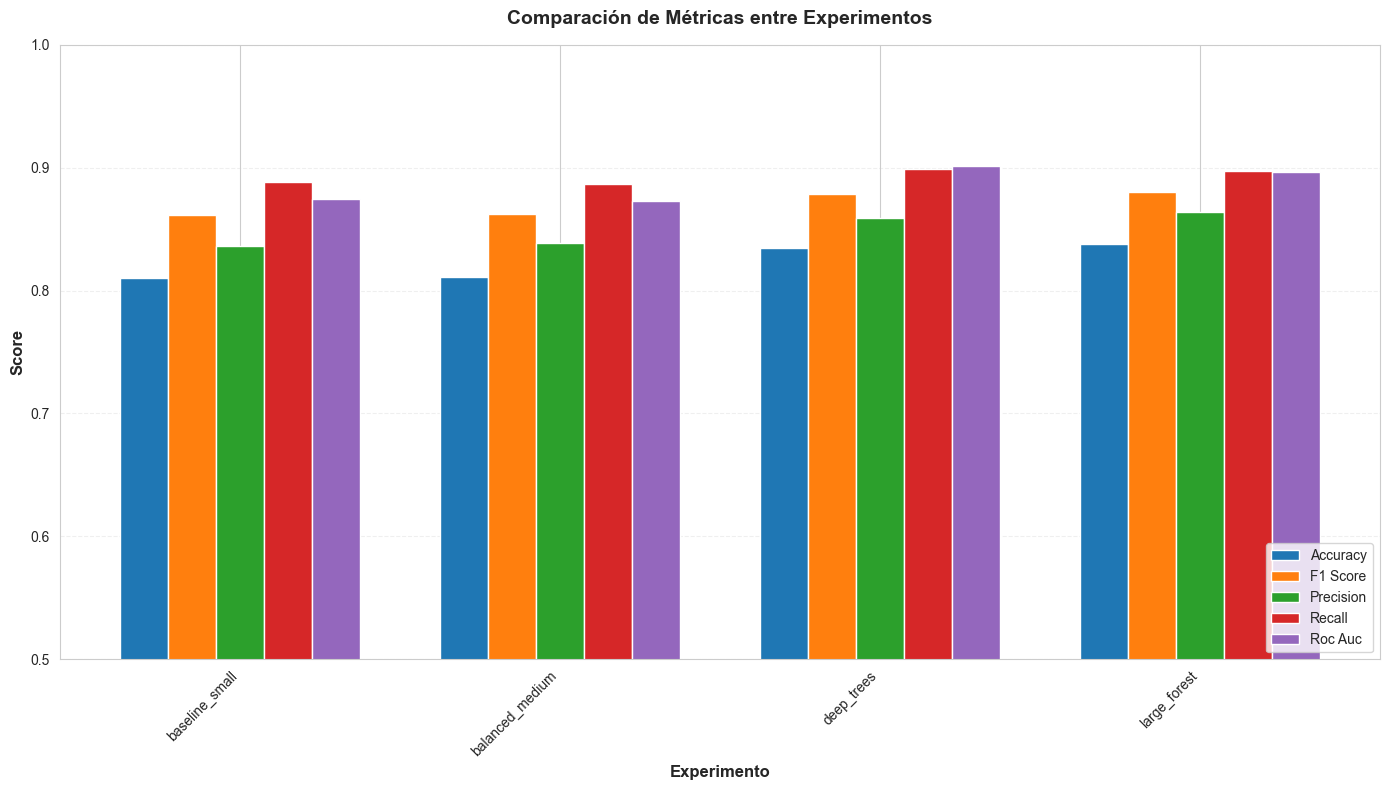


 Guardando comparativa de experimentos...


In [55]:
    results_df = pd.DataFrame(results)

    print("Resultados de todos los experimentos:\n")
    display_cols = ['experiment', 'name', 'n_estimators', 'max_depth',
                    'accuracy', 'f1_score', 'roc_auc', 'training_time_seconds']
    print(results_df[display_cols].to_string(index=False))

    # Encontrar mejor modelo
    best_metric = 'accuracy'
    best_idx = results_df[best_metric].idxmax()
    best_run = results_df.iloc[best_idx]

    print(f"\n MEJOR MODELO (según {best_metric}):")
    print(f"  Experimento: {best_run['experiment']} - {best_run['name']}")
    print(f"  Configuración:")
    print(f"    - n_estimators: {best_run['n_estimators']}")
    print(f"    - max_depth: {best_run['max_depth']}")
    print(f"    - min_samples_split: {best_run['min_samples_split']}")
    print(f"  Métricas:")
    print(f"    - Accuracy:  {best_run['accuracy']:.4f}")
    print(f"    - F1-Score:  {best_run['f1_score']:.4f}")
    print(f"    - Precision: {best_run['precision']:.4f}")
    print(f"    - Recall:    {best_run['recall']:.4f}")
    print(f"    - ROC-AUC:   {best_run['roc_auc']:.4f}")
    print(f"  Run ID: {best_run['run_id']}")

    # Comparativa visual
    plt.figure(figsize=(14, 8))

    metrics_to_plot = ['accuracy', 'f1_score', 'precision', 'recall', 'roc_auc']
    x = np.arange(len(experiments))
    width = 0.15

    for idx, metric in enumerate(metrics_to_plot):
        offset = width * (idx - 2)
        plt.bar(x + offset, results_df[metric], width,
                label=metric.replace('_', ' ').title())

    plt.xlabel('Experimento', fontsize=12, fontweight='bold')
    plt.ylabel('Score', fontsize=12, fontweight='bold')
    plt.title('Comparación de Métricas entre Experimentos',
              fontsize=14, fontweight='bold', pad=15)
    plt.xticks(x, results_df['name'], rotation=45, ha='right')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.ylim([0.5, 1.0])
    plt.tight_layout()
    comparison_path = f'{temp_artifacts_dir}/experiments_comparison.png'
    plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
    plt.show()

    # Guardar comparativa como artifact en el experimento
    print(f"\n Guardando comparativa de experimentos...")

## 6.1. Registro en el Model Registry.

In [56]:
    model_name = "wine-quality-classifier"
    best_model_uri = f"runs:/{best_run['run_id']}/model"

    print(f" Registrando mejor modelo en Model Registry...")
    print(f"  Modelo: {model_name}")
    print(f"  Run ID: {best_run['run_id']}")
    print(f"  Experimento: {best_run['name']}")

    model_tags = {
        "model_type": "RandomForest",
        "experiment_config": best_run['name'],
        "training_date": datetime.now().strftime("%Y-%m-%d"),
        "best_metric": best_metric,
        "accuracy": str(round(best_run['accuracy'], 4)),
        "f1_score": str(round(best_run['f1_score'], 4)),
        "roc_auc": str(round(best_run['roc_auc'], 4)),
        "n_estimators": str(best_run['n_estimators']),
        "max_depth": str(best_run['max_depth']),
        "dataset": "winequality",
        "author": "tobias"
    }

    registered_model = mlflow.register_model(
        model_uri=best_model_uri,
        name=model_name,
        tags=model_tags
    )

    print(f"\n Modelo registrado:")
    print(f"  Nombre: {model_name}")
    print(f"  Versión: {registered_model.version}")

    model_description = f"""
        Modelo de clasificación binaria para predecir la calidad de vino blanco basándose en
        propiedades fisicoquímicas. Clasifica vinos como **Alta Calidad (≥6)** o **Baja Calidad (<6)**.

        Mejor Configuración Encontrada:
        - **Algoritmo:** Random Forest Classifier
        - **Configuración:** {best_run['name']}
        - **N° de árboles:** {best_run['n_estimators']}
        - **Profundidad máxima:** {best_run['max_depth']}
        - **Min samples split:** {best_run['min_samples_split']}
        - **Random state:** {random_state}

        ## Performance en Test Set
        | Métrica | Valor |
        |---------|-------|
        | Accuracy | {best_run['accuracy']:.4f} |
        | F1-Score | {best_run['f1_score']:.4f} |
        | Precision | {best_run['precision']:.4f} |
        | Recall | {best_run['recall']:.4f} |
        | ROC-AUC | {best_run['roc_auc']:.4f} |
        ---
        """

    client.update_registered_model(
        name=model_name,
        description=model_description
    )

    print(f"✓ Descripción del modelo actualizada")

    # Agregar descripción a la versión específica
    version_description = f"""
        ## Versión {registered_model.version} - {best_run['name']}

        ### Configuración
        - **n_estimators:** {best_run['n_estimators']}
        - **max_depth:** {best_run['max_depth']}
        - **min_samples_split:** {best_run['min_samples_split']}

        ### Métricas
        - **Accuracy:** {best_run['accuracy']:.4f}
        - **F1-Score:** {best_run['f1_score']:.4f}
        - **Precision:** {best_run['precision']:.4f}
        - **Recall:** {best_run['recall']:.4f}
        - **ROC-AUC:** {best_run['roc_auc']:.4f}

        ### Información
        - **Run ID:** {best_run['run_id']}
        """

    client.update_model_version(
        name=model_name,
        version=registered_model.version,
        description=version_description
    )

    print(f"✓ Descripción de la versión actualizada")

Successfully registered model 'wine-quality-classifier'.
2025/11/07 18:36:33 WARNING mlflow.tracking._model_registry.fluent: Run with id f8dca8c791f646d68ba8cf142d6b57fe has no artifacts at artifact path 'model', registering model based on models:/m-758c7871bb534951bf29dca7af0f2ce3 instead


 Registrando mejor modelo en Model Registry...
  Modelo: wine-quality-classifier
  Run ID: f8dca8c791f646d68ba8cf142d6b57fe
  Experimento: large_forest


2025/11/07 18:36:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: wine-quality-classifier, version 1



 Modelo registrado:
  Nombre: wine-quality-classifier
  Versión: 1
✓ Descripción del modelo actualizada
✓ Descripción de la versión actualizada


Created version '1' of model 'wine-quality-classifier'.


## 6.2. Transición a Staging.

In [57]:
    client.transition_model_version_stage(
        name=model_name,
        version=registered_model.version,
        stage="Staging",
        archive_existing_versions=False
    )

    # Agregar tags adicionales a la versión
    version_tags = {
        "promoted_to_staging": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "selected_by": best_metric,
        "experiment_number": str(best_run['experiment'])
    }

    for tag_key, tag_value in version_tags.items():
        client.set_model_version_tag(
            name=model_name,
            version=registered_model.version,
            key=tag_key,
            value=tag_value
        )

    print(f"✓ Tags de versión agregados")

✓ Tags de versión agregados


## 6.3. Promoción a Production.

In [58]:
    staging_model = mlflow.sklearn.load_model(f"models:/{model_name}/Staging")
    print("✓ Modelo cargado correctamente")

    client.transition_model_version_stage(
        name=model_name,
        version=registered_model.version,
        stage="Production",
        archive_existing_versions=True
    )

    production_tags = {
        "promoted_to_production": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "promotion_status": "approved"
    }

    for tag_key, tag_value in production_tags.items():
        client.set_model_version_tag(
            name=model_name,
            version=registered_model.version,
            key=tag_key,
            value=tag_value
        )

    print(f" Modelo promovido a PRODUCTION")
    print(f"   Versión: {registered_model.version}")
    print("Notebook ejecutado completamente")

✓ Modelo cargado correctamente
 Modelo promovido a PRODUCTION
   Versión: 1
Notebook ejecutado completamente
